In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("API_KEY")

In [2]:
import numpy as np
import pandas as pd
from mosqlient.scoring import Scorer
from format_data import filter_agg_data

In [3]:
import warnings 
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [4]:
import matplotlib as mpl
from epiweeks import Week
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Set date format with newline between month and year
date_fmt = mdates.DateFormatter('%b\n%Y')  # e.g., Jun\n2025

# Definir a cor das bordas (spines) como cinza
mpl.rcParams['axes.edgecolor'] = 'gray'

# Definir a cor das linhas dos ticks maiores e menores como cinza
mpl.rcParams['xtick.color'] = 'gray'
mpl.rcParams['ytick.color'] = 'gray'
mpl.rcParams['xtick.labelcolor'] = 'black'
mpl.rcParams['ytick.labelcolor'] = 'black'
plt.rcParams['axes.labelsize'] = 16 # Axis labels
plt.rcParams['xtick.labelsize'] = 14  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Y-axis tick labels
plt.rcParams['font.size'] = 16  # General font size

In [5]:
state = 'MS'
YEAR = 2023

In [6]:
df_casos = filter_agg_data(state)
df_for = pd.read_csv(f'forecast_tables/for_2023_{state}.csv')

In [7]:
df_w_lin = pd.read_csv(f'forecast_tables/weights_linear_{state}_for_{YEAR}.csv.gz')
df_w_log = pd.read_csv(f'forecast_tables/weights_log_{state}_for_{YEAR}.csv.gz')
df_w_crps= pd.read_csv(f'forecast_tables/weights_crps_{state}_for_{YEAR}.csv.gz')
df_ens_lin_end= pd.read_csv(f'forecast_tables/ensemble_linear_{state}_for_{YEAR}.csv.gz')
df_ens_lin_end_equal = pd.read_csv(f'forecast_tables/ensemble_linear_equal_{state}_for_{YEAR}.csv.gz')
df_ens_log_end= pd.read_csv(f'forecast_tables/ensemble_log_{state}_for_{YEAR}.csv.gz')
df_ens_log_end_equal= pd.read_csv(f'forecast_tables/ensemble_log_equal_{state}_for_{YEAR}.csv.gz')
df_ens_lin_end_crps= pd.read_csv(f'forecast_tables/ensemble_linear_crps_{state}_for_{YEAR}.csv.gz')
df_ens_log_end_crps= pd.read_csv(f'forecast_tables/ensemble_crps_log_{state}_for_{YEAR}.csv.gz')

for df in [df_casos, df_for, df_w_lin, df_w_log,df_w_crps,  df_ens_lin_end, df_ens_log_end, df_ens_lin_end_crps,df_ens_log_end_crps ]:
    try: 
        df['date'] = pd.to_datetime(df['date'])
    except: pass

Define the step and range of dates:

In [8]:
step =1
start_ = str(Week(YEAR,2).startdate())
end_ = str(Week(YEAR,52).startdate())

In [9]:
df_casos_f = df_casos.loc[
                        (df_casos.date >= start_) & (df_casos.date <= end_)
]

df_for_f = df_for.loc[
                     (df_for.date >= start_) & (df_for.date <= end_)
]

df_ens_lin_ = df_ens_lin_end.loc[df_ens_lin_end.step == step].sort_values(by = 'date')

df_ens_lin_equal_ = df_ens_lin_end_equal.loc[df_ens_lin_end_equal.step == step].sort_values(by = 'date')

df_ens_log_ = df_ens_log_end.loc[df_ens_log_end.step == step].sort_values(by = 'date')

df_ens_log_equal_ = df_ens_log_end_equal.loc[df_ens_log_end_equal.step == step].sort_values(by = 'date')

df_ens_lin_crps_ = df_ens_lin_end_crps.loc[df_ens_lin_end_crps.step == step].sort_values(by = 'date')

df_ens_log_crps_ = df_ens_log_end_crps.loc[df_ens_log_end_crps.step == step].sort_values(by = 'date')

df_for_ = df_for_f.loc[df_for_f.step == step].sort_values(by = 'date')

Compute the CRPS scores of the forecast and the ensembles:

In [10]:
def compute_scores(metric, df_casos_f, df_for_, dfs = [df_ens_lin_, df_ens_log_, df_ens_lin_crps_, df_ens_log_crps_], dfs_name = ['ensemble_linear', 'ensemble_log', 'ensemble_linear_crps', 'ensemble_log_crps'] ): 

    scores=[]

    scores_CRPS = []

    for m in ['arima', 'gp', 'lstm']:
        score_model = Scorer(api_key,
                      df_true = df_casos_f,
                      pred=df_for_.loc[df_for_.model == m].rename(columns = {'lower': 'lower_95',
                                                            'upper':'upper_95'}),
                      dist='log_normal',
                      fn_loss='median',
                      conf_level=0.95)

        scores_CRPS.append(pd.DataFrame(score_model.crps[0]['pred'], columns = [f'CRPS_{m}']))
        
        if METRIC == 'RMSE':
            scores.append(pd.DataFrame([np.sqrt(score_model.mse['pred'])], columns = [f'{m}']))
    
        if METRIC == 'LOG_SCORE':
            scores.append(pd.DataFrame([score_model.log_score[1]['pred']], columns = [f'{m}']))
    
        if METRIC == 'CRPS':
            scores.append(pd.DataFrame([score_model.crps[1]['pred']], columns = [f'{m}']))
    
    for df_, name in zip(dfs, dfs_name): 
    
        score_model = Scorer(api_key,
                      df_true = df_casos_f,
                      pred=df_,
                      dist='log_normal',
                      fn_loss='median',
                      conf_level=0.95)
        
        scores_CRPS.append(pd.DataFrame(score_model.crps[0]['pred'], columns = [f'CRPS_{name}']))

        if metric == 'RMSE':
            scores.append(pd.DataFrame([np.sqrt(score_model.mse['pred'])], columns = [f'{name}']))
    
        if metric == 'LOG_SCORE':
            scores.append(pd.DataFrame([score_model.log_score[1]['pred']], columns = [f'{name}']))
    
        if metric == 'CRPS':
            scores.append(pd.DataFrame([score_model.crps[1]['pred']], columns = [f'{name}']))

    df_scores_CRPS = pd.concat(scores_CRPS, axis =1).dropna()

    df_scores_metric = pd.concat(scores, axis =1).dropna()
    
    df_scores_metric = df_scores_metric.rename(columns= { 
                                                   'ensemble_linear': 'E - Linear', 
                                                   'ensemble_log': 'E - Log',
                                                   'ensemble_linear_crps': 'E - Linear\n(W-Inv. CRPS)', 
                                                   'ensemble_log_crps': 'E - Log\n(W-Inv. CRPS)'})
    
    df_scores_metric = df_scores_metric.T.rename(columns = {0:metric})

    return df_scores_CRPS, df_scores_metric 


Compute Log Score or RMSE for the models:

In [11]:
METRIC = 'LOG_SCORE'

In [12]:
df_scores, df_scores_metric = compute_scores(METRIC,
                                  df_casos_f,
                                  df_for_,
                                  dfs = [df_ens_lin_, df_ens_lin_equal_, df_ens_log_, df_ens_log_equal_, df_ens_lin_crps_, df_ens_log_crps_],
                                  dfs_name = ['ensemble_linear','ensemble_linear_equal', 'ensemble_log', 'ensemble_log_equal', 'ensemble_linear_crps', 'ensemble_log_crps'] )

In [13]:
df_scores_metric

,LOG_SCORE
arima,-7.393538
gp,-7.375178
lstm,-10.978651
E - Linear,-8.027887
ensemble_linear_equal,-7.475627
E - Log,-7.341649
ensemble_log_equal,-7.571781
E - Linear\n(W-Inv. CRPS),-7.390541
E - Log\n(W-Inv. CRPS),-7.511693


Plot the results:

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_14564/343857782.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[2,0].axhline(df_scores_metric_.loc[['arima', 'gp', 'lstm']].max()[0], color = 'black', linestyle = '--')


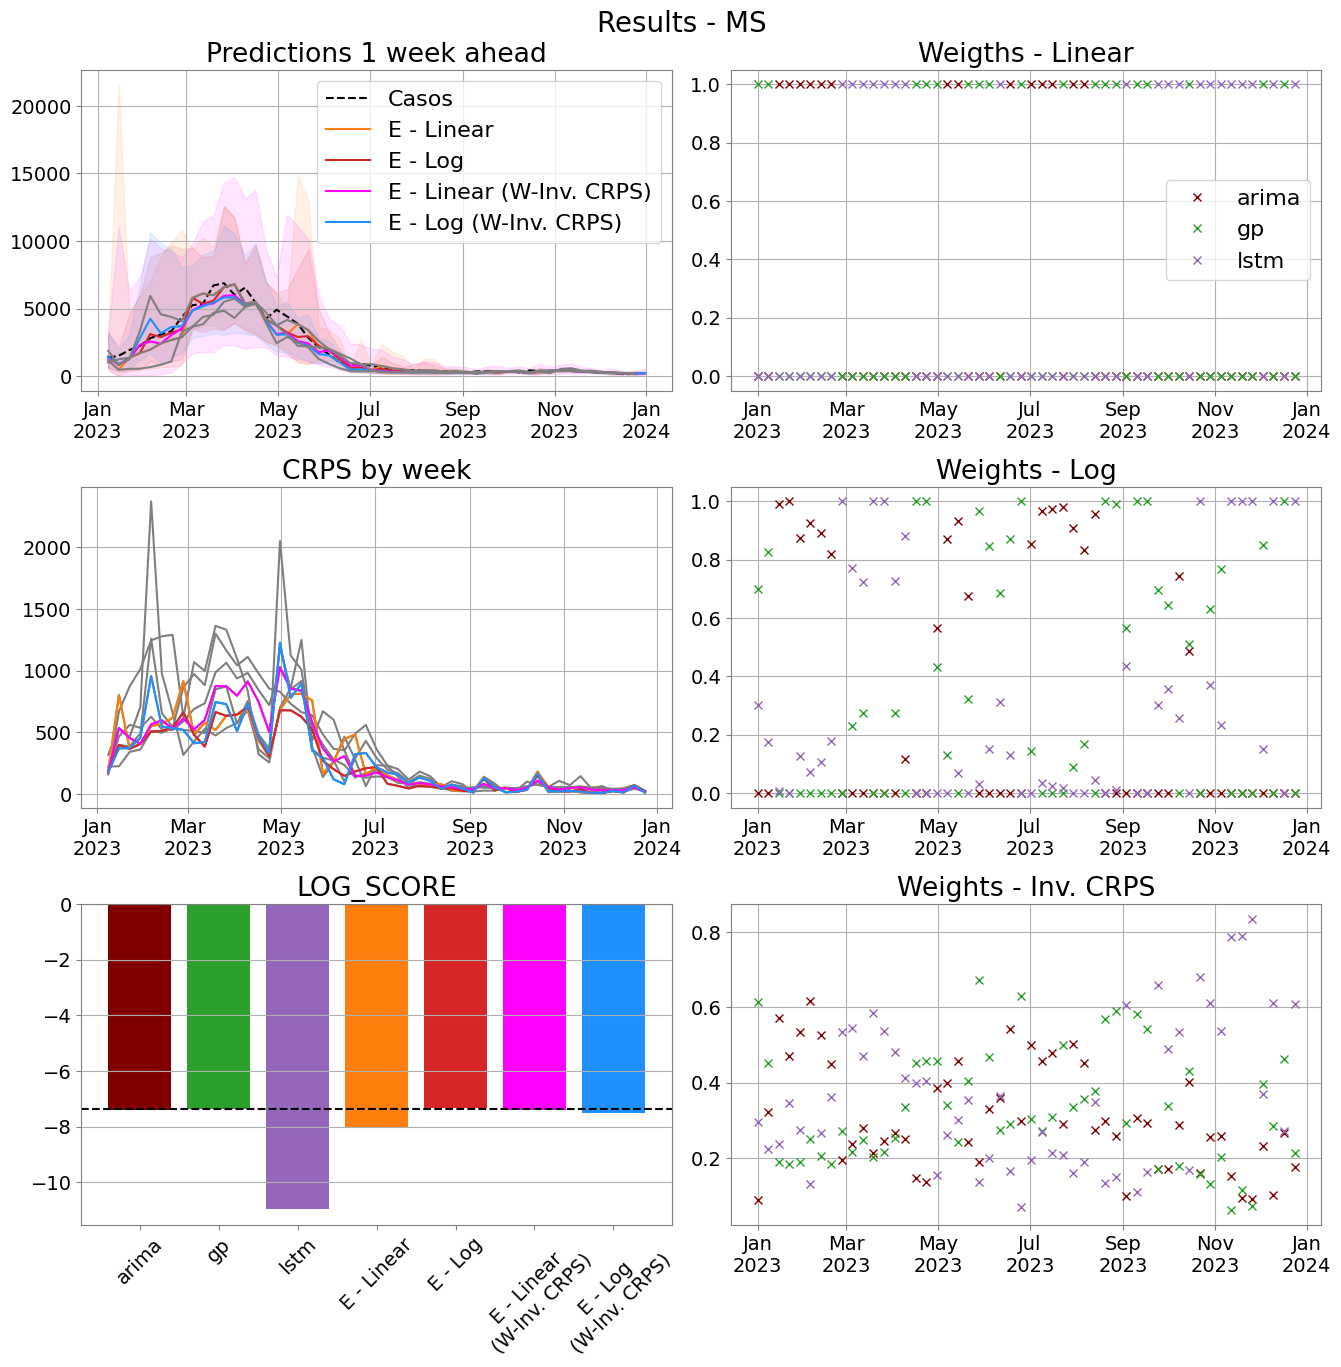

In [25]:
_,ax = plt.subplots(3, 2, figsize = (16,15))

ax[0,0].plot(df_casos_f.date, df_casos_f.casos, color = 'black', label = 'Casos', linestyle = '--')

for df, color, name in zip([df_ens_lin_, df_ens_log_, df_ens_lin_crps_, df_ens_log_crps_], ['tab:orange', 'tab:red', 'magenta', 'dodgerblue'],
                          ['E - Linear', 'E - Log', 'E - Linear (W-Inv. CRPS)', 'E - Log (W-Inv. CRPS)']):

    ax[0,0].plot(df.date, df.pred, color = color, label = name)
    ax[0,0].fill_between(df.date, df.lower_95, df.upper_95, color=color, alpha = 0.1)

for model in ['arima', 'gp', 'lstm']: 
    df_pred_ = df_for_.loc[df_for_.model == model]
    ax[0,0].plot(df_pred_.date, df_pred_.pred, color = 'tab:gray')

ax[0,0].grid()
ax[0,0].legend()

ax[0,0].set_title(f'Predictions {step} week ahead')

ax[0,1].plot(df_w_lin.date, df_w_lin.weights_1, marker='x', linestyle='None', label = 'arima', color= 'maroon')
ax[0,1].plot(df_w_lin.date, df_w_lin.weights_2, marker='x', linestyle='None', label = 'gp',  color= 'tab:green')
ax[0,1].plot(df_w_lin.date, df_w_lin.weights_3, marker='x', linestyle='None', label = 'lstm',  color= 'tab:purple')

ax[1,1].plot(df_w_log.date, df_w_log.weights_1, marker='x', linestyle='None' , label = 'arima',  color= 'maroon')
ax[1,1].plot(df_w_log.date, df_w_log.weights_2, marker='x', linestyle='None', label = 'gp',  color= 'tab:green')
ax[1,1].plot(df_w_log.date, df_w_log.weights_3, marker='x', linestyle='None', label = 'lstm',  color= 'tab:purple')

ax[2,1].plot(df_w_crps.date, df_w_crps.weights_1, marker='x', linestyle='None' , label = 'arima',  color= 'maroon')
ax[2,1].plot(df_w_crps.date, df_w_crps.weights_2, marker='x', linestyle='None', label = 'gp',  color= 'tab:green')
ax[2,1].plot(df_w_crps.date, df_w_crps.weights_3, marker='x', linestyle='None', label = 'lstm',  color= 'tab:purple')

ax[0,1].set_title('Weigths - Linear')
ax[1,1].set_title('Weights - Log')
ax[2,1].set_title('Weights - Inv. CRPS')

ax[0,1].legend()

ax[0,1].grid()
ax[1,1].grid()
ax[2,1].grid()

for col in df_scores.columns: 

    ax[1,0].plot(df_scores[col], color = 'tab:grey')

ax[1,0].plot(df_scores['CRPS_ensemble_linear'], color = 'tab:orange')
ax[1,0].plot(df_scores['CRPS_ensemble_log'], color = 'tab:red')
ax[1,0].plot(df_scores['CRPS_ensemble_linear_crps'], color = 'magenta')
ax[1,0].plot(df_scores['CRPS_ensemble_log_crps'], color = 'dodgerblue')

ax[1,0].grid()
ax[2,0].grid(axis ='y')
ax[1,0].set_title('CRPS by week')

df_scores_metric_ = df_scores_metric.loc[~df_scores_metric.index.isin(['ensemble_linear_equal', 'ensemble_log_equal'])]

ax[2,0].bar(x = df_scores_metric_.index, height = df_scores_metric_[METRIC], color = ['maroon', 'tab:green', 'tab:purple', 
                                                                       'tab:orange', 'tab:red', 'magenta', 'dodgerblue'])

if METRIC == 'RMSE': 
    ax[2,0].axhline(df_scores_metric_.loc[['arima', 'gp', 'lstm']].min()[0], color = 'black', linestyle = '--')
    
if METRIC == 'LOG_SCORE':
    ax[2,0].axhline(df_scores_metric_.loc[['arima', 'gp', 'lstm']].max()[0], color = 'black', linestyle = '--')

ax[2,0].set_title(f'{METRIC}')

for label in ax[2,0].get_xticklabels():
        label.set_rotation(45)


ax[0,1].xaxis.set_major_formatter(date_fmt)
ax[1,1].xaxis.set_major_formatter(date_fmt)
ax[2,1].xaxis.set_major_formatter(date_fmt)
ax[0,0].xaxis.set_major_formatter(date_fmt)
ax[1,0].xaxis.set_major_formatter(date_fmt)

plt.subplots_adjust(hspace = 0.3, wspace=0.1)
plt.suptitle(f'Results - {state}', fontsize =20, y = 0.92)
plt.savefig(f'figures/summary_{state}.png', dpi = 300)
plt.show()

In [15]:
df_ranking = pd.DataFrame()

df_ranking['linear'] = df_w_lin[['weights_1', 'weights_2', 'weights_3']].idxmax(axis=1)
df_ranking['log'] = df_w_log[['weights_1', 'weights_2', 'weights_3']].idxmax(axis=1)
df_ranking['crps'] = df_w_crps[['weights_1', 'weights_2', 'weights_3']].idxmax(axis=1)
df_ranking = df_ranking.dropna()
df_ranking.head()

,linear,log,crps
0,weights_2,weights_2,weights_2
1,weights_2,weights_2,weights_2
2,weights_1,weights_1,weights_1
3,weights_1,weights_1,weights_1
4,weights_1,weights_1,weights_1


In [16]:
df_ranking.loc[df_ranking.linear == df_ranking.crps].shape

(52, 3)

In [17]:
df_ranking.loc[df_ranking.linear == df_ranking.log].shape

(40, 3)

In [18]:
df_ranking.loc[df_ranking.crps == df_ranking.log].shape

(40, 3)

Plot do CRPS considerando também os modelos com pesos iguais:

In [19]:
df_scores_mean = pd.DataFrame(df_scores.mean(), columns = ['CRPS'])

df_scores_mean = df_scores_mean.rename(index= {'CRPS_arima':'arima', 
                                               'CRPS_gp':'gp',
                                               'CRPS_lstm': 'lstm', 
                                               'CRPS_ensemble_linear': 'E - Linear', 
                                               'CRPS_ensemble_log': 'E - Log',
                                               'CRPS_ensemble_linear_crps': 'E - Linear\n(W-CRPS)', 
                                               'CRPS_ensemble_log_crps': 'E - Log\n(W-CRPS)', 
                                               'CRPS_ensemble_linear_equal': 'E - Linear\n(equal)', 
                                               'CRPS_ensemble_log_equal': 'E - Log\n(equal)'	
                                              })


In [20]:
df_scores_mean

,CRPS
arima,348.896684
gp,403.655817
lstm,384.497225
E - Linear,290.167039
E - Linear\n(equal),335.163652
E - Log,248.021214
E - Log\n(equal),310.495888
E - Linear\n(W-CRPS),309.682854
E - Log\n(W-CRPS),280.176695


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_14564/4201462975.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axhline(df_scores_mean.loc[['arima', 'gp', 'lstm']].min()[0], color = 'black', linestyle = '--')


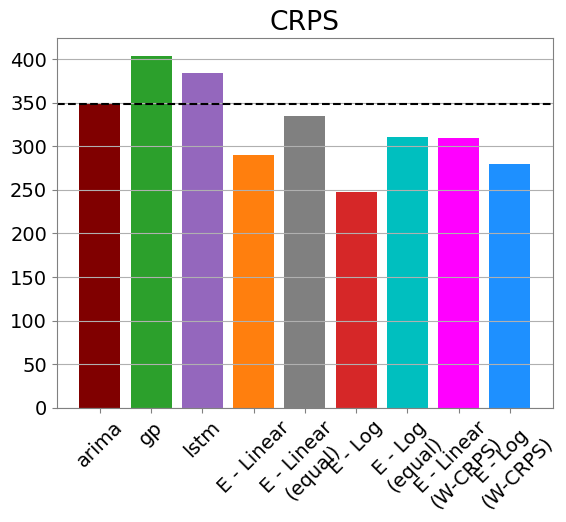

In [24]:
_,ax = plt.subplots()

ax.bar(x = df_scores_mean.index, height = df_scores_mean['CRPS'], color = ['maroon', 'tab:green', 'tab:purple', 
                                                                       'tab:orange',  'gray', 'tab:red',  'c', 'magenta', 'dodgerblue'])

ax.axhline(df_scores_mean.loc[['arima', 'gp', 'lstm']].min()[0], color = 'black', linestyle = '--')
    

ax.set_title(f'CRPS')
ax.grid(axis = 'y')
for label in ax.get_xticklabels():
        label.set_rotation(45)